In [11]:
import pandas as pd
import numpy as np
import os
from plotnine import *

## Sanity check: read coverage file into a dataframe

In [2]:
cov = []
for strand in ['fwd', 'rev']:
    df = pd.read_csv('../results/yoon01/lncRNA_locus.{}.cov.gz'.format(strand),
                     usecols=[1,2], sep='\t', header=None, names=['position', 'coverage'])
    df['strand'] = '+' if strand=='fwd' else '-'
    cov.append(df)
    
covdf = pd.concat(cov)
covdf

,position,coverage,strand
0,1,0.0,+
1,2,0.0,+
2,3,0.0,+
3,4,0.0,+
4,5,0.0,+
5,6,0.0,+
6,7,0.0,+
7,8,0.0,+
8,9,0.0,+
9,10,0.0,+


## Build `GTF` dataframe from the `lncRNA` annotation file

In [3]:
def gtf_df(filename):
    res = []
    with open(filename, 'rt') as fi:
        for line in fi:
            fields = line.strip().split('\t')
            if fields[2] == 'exon':
                rec = {}
                idfields = fields[8].strip().split(';')
                for idfield in idfields:
                    if idfield:
                        key, val = idfield.split()
                        if key == 'transcript_id' or key == 'exon_number':
                            rec.update({key: val.strip('"')})

                rec.update({'chr': fields[0],
                          'start': int(fields[3]),
                          'end': int(fields[4])})
                res.append(rec)
    return pd.DataFrame.from_records(res)

In [4]:
gtf = gtf_df('../ref/lncRNA.gtf')
gtf

,chr,end,exon_number,start,transcript_id
0,chr2,137087174,1,137086878,TCONS_tallLncRNA_00203783
1,chr2,137087502,2,137087403,TCONS_tallLncRNA_00203783
2,chr2,137087222,1,137086878,TCONS_tallLncRNA_00203782
3,chr2,137087502,2,137087381,TCONS_tallLncRNA_00203782
4,chr2,137086987,1,137086771,lnrCXCR4
5,chr2,137087419,2,137087039,lnrCXCR4
6,chr2,137087809,3,137087491,lnrCXCR4
7,chr2,137087483,1,137087011,ENST00000392399.3


In [5]:
gtf['exon'] = ['exon {}'.format(x.exon_number) for _,x in gtf.iterrows()]
gtf['strand'] = '-'
gtf['track'] = gtf['transcript_id']
gtf

,chr,end,exon_number,start,transcript_id,exon,strand,track
0,chr2,137087174,1,137086878,TCONS_tallLncRNA_00203783,exon 1,-,TCONS_tallLncRNA_00203783
1,chr2,137087502,2,137087403,TCONS_tallLncRNA_00203783,exon 2,-,TCONS_tallLncRNA_00203783
2,chr2,137087222,1,137086878,TCONS_tallLncRNA_00203782,exon 1,-,TCONS_tallLncRNA_00203782
3,chr2,137087502,2,137087381,TCONS_tallLncRNA_00203782,exon 2,-,TCONS_tallLncRNA_00203782
4,chr2,137086987,1,137086771,lnrCXCR4,exon 1,-,lnrCXCR4
5,chr2,137087419,2,137087039,lnrCXCR4,exon 2,-,lnrCXCR4
6,chr2,137087809,3,137087491,lnrCXCR4,exon 3,-,lnrCXCR4
7,chr2,137087483,1,137087011,ENST00000392399.3,exon 1,-,ENST00000392399.3


## Second annotation dataframe will only have `lnrCXCR4` and `UBBP1`

In [6]:
# `exon 1` and `exon 3` are swapped in the .gtf file
# we correct it here

gtf_ = gtf.loc[4:,:]
gtf_.loc[4,'exon'] = 'exon 3'
gtf_.loc[6,'exon'] = 'exon 1'
gtf_.loc[7, 'track'] = 'UBBP1'
gtf_

/home/ilya/.venv/pydata3/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,chr,end,exon_number,start,transcript_id,exon,strand,track
4,chr2,137086987,1,137086771,lnrCXCR4,exon 3,-,lnrCXCR4
5,chr2,137087419,2,137087039,lnrCXCR4,exon 2,-,lnrCXCR4
6,chr2,137087809,3,137087491,lnrCXCR4,exon 1,-,lnrCXCR4
7,chr2,137087483,1,137087011,ENST00000392399.3,exon 1,-,UBBP1


## Plotting functions

In [7]:
# Need to convert .bam coords to genomic coords compatible with .gtf

OFFSET = gtf.start.min() - 501

In [17]:
def feature_df(gff, features, feature_col='gene'):
    if isinstance(features, str):
        features = [features]
    g = gff[gff[feature_col].isin(features)].copy()
    g['length'] = np.abs(g.end - g.start)
    return g

def cond_df(region, sample, res_dir='../results', strands=('fwd','rev')):
    '''
    For condition coverage calculated in
    xx - Genome coverage by condition
    '''
    cov = []
    if strands is None:
        df = pd.read_csv(os.path.join(res_dir, sample, 'lncRNA_locus.cov.gz'),
                         usecols=[1,2], sep='\t', header=None, 
                         names=['position', 'coverage'])
    else:
        for strand in strands:
            df = pd.read_csv(os.path.join(res_dir, sample, 'lncRNA_locus.{strand}.cov.gz'.format(
                                strand=strand)),
                             usecols=[1,2], sep='\t', header=None, 
                             names=['position', 'coverage'])
            df['strand'] = '+' if strand==strands[0] else '-'
            
    df['position'] += OFFSET
    start,end = region
    df = df[(df['position']>start) & (df['position']<end)]
    cov.append(df)
    data = pd.concat(cov)
    return data


def region_plot(region, sample, strand='+', features=None, padding=None):
    if features is not None:
        region = (np.min(features['start']), np.max(features['end']))
        if strand is not None:
            strand = list(set(features['strand']))[0]
    if padding is not None:
        region = region[0] - padding, region[1] + padding
        
    if strand is None:
        data = cond_df(region, sample, strands=None)
        data.loc[data['coverage']<0, 'coverage'] = 0
    else:
        data = cond_df(region, sample)
        data = data[data['strand']==strand]
    fmark = '>' if strand == '+' else '<'
    g = ggplot(data, aes('position', 'coverage'))
    g += geom_area(alpha=0.25)
    if features is not None:
        anno_list = []
        ymax = -(np.max(data['coverage']))
        features['center'] = features['start'] + features['length'] // 2
        for i,track in enumerate(set(features['track'])):
            features.loc[features['track']==track, 'fy'] = (i+1)*0.125*ymax
        g += geom_tile(features, aes(x='center', y='fy', width='length', fill='track', height=0.1*ymax),
                       alpha=0.15)
        g += geom_text(features, aes(x='center', y='fy', label='exon'), alpha=0.5, size=24)
        g += geom_text(features, aes(x='start + length // 5', y='fy'), label=fmark, size=20, alpha=0.5)
    if strand =='-':
        g += scale_y_reverse()
    g += theme_bw()
    g += theme(figure_size=(18,12),
               axis_title_x=element_text(size=28),
               axis_title_y=element_text(size=28),
               axis_text_x=element_text(size=22),
               axis_text_y=element_text(size=22),
               legend_text=element_text(size=24),
               legend_title=element_text(size=28),
               legend_entry_spacing_y=15
               )
    return g

## Locus coverage plots

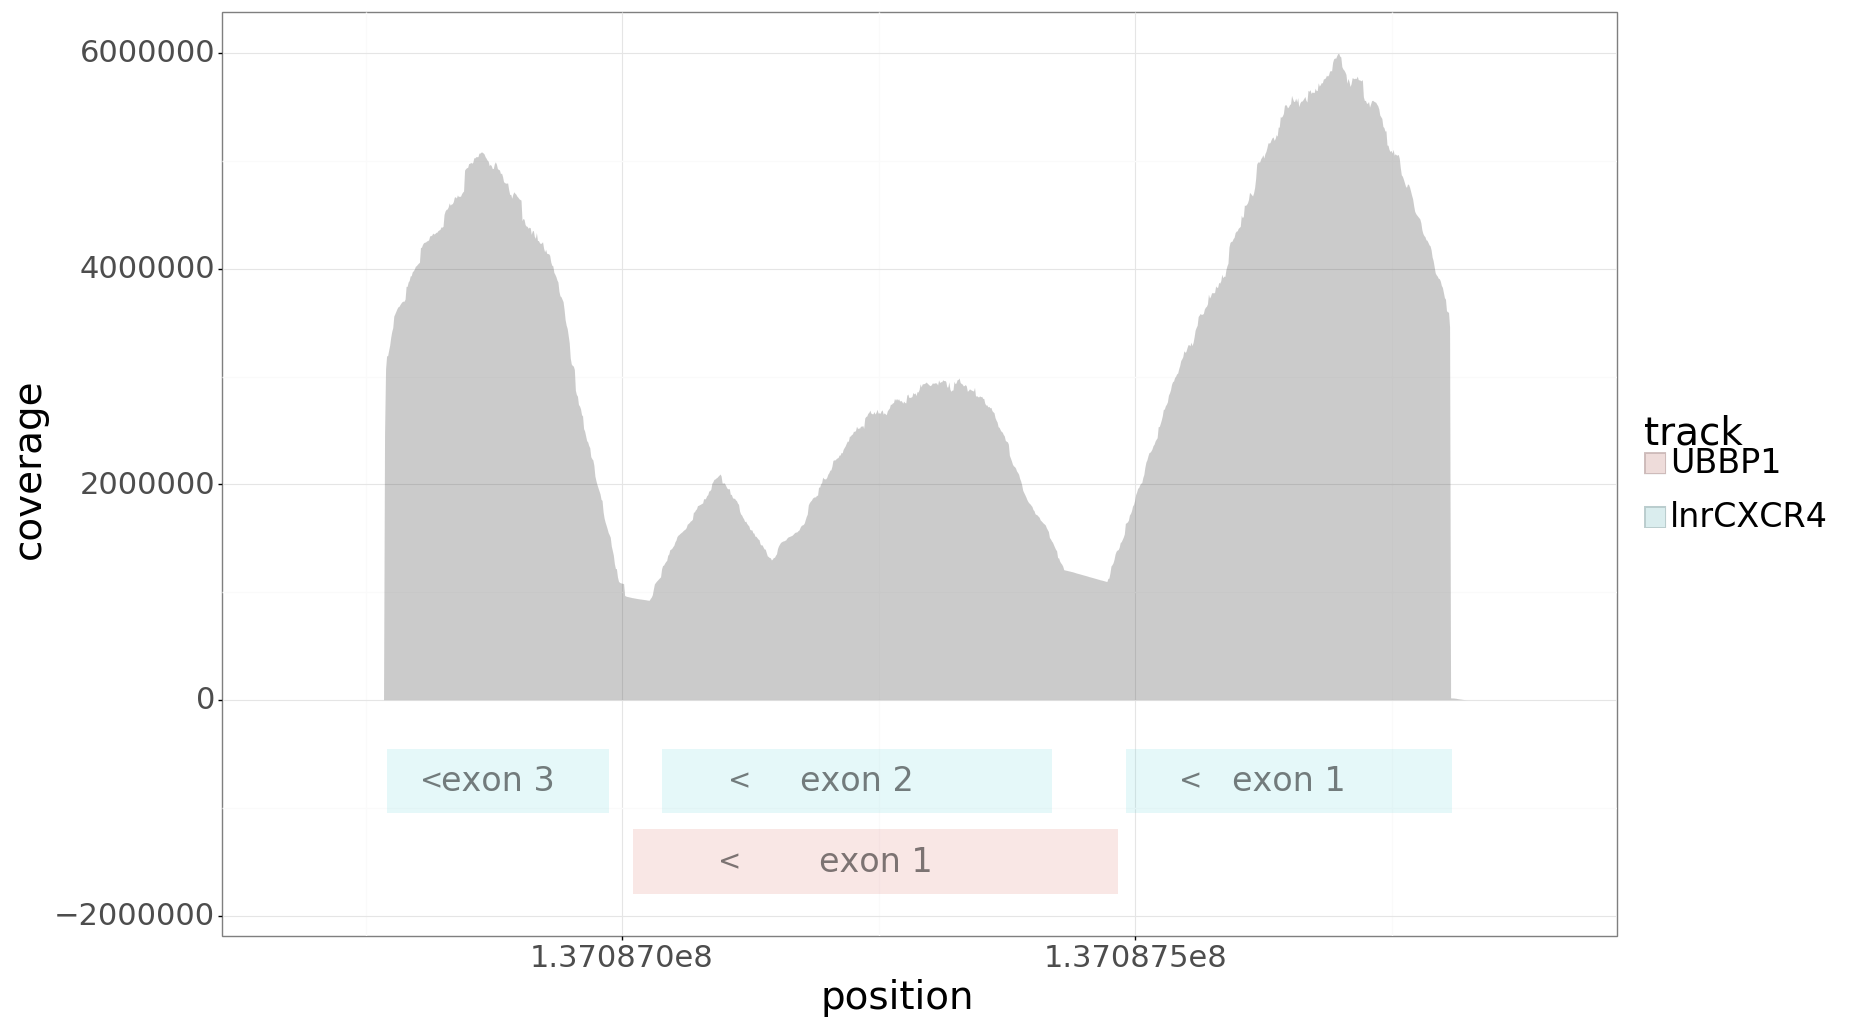

<ggplot: (-9223363259218973005)>

In [16]:
region_plot(None, 'yoon01', padding=100, strand=None,
            features=feature_df(gtf_, list(gtf_['exon'].values), feature_col='exon'))

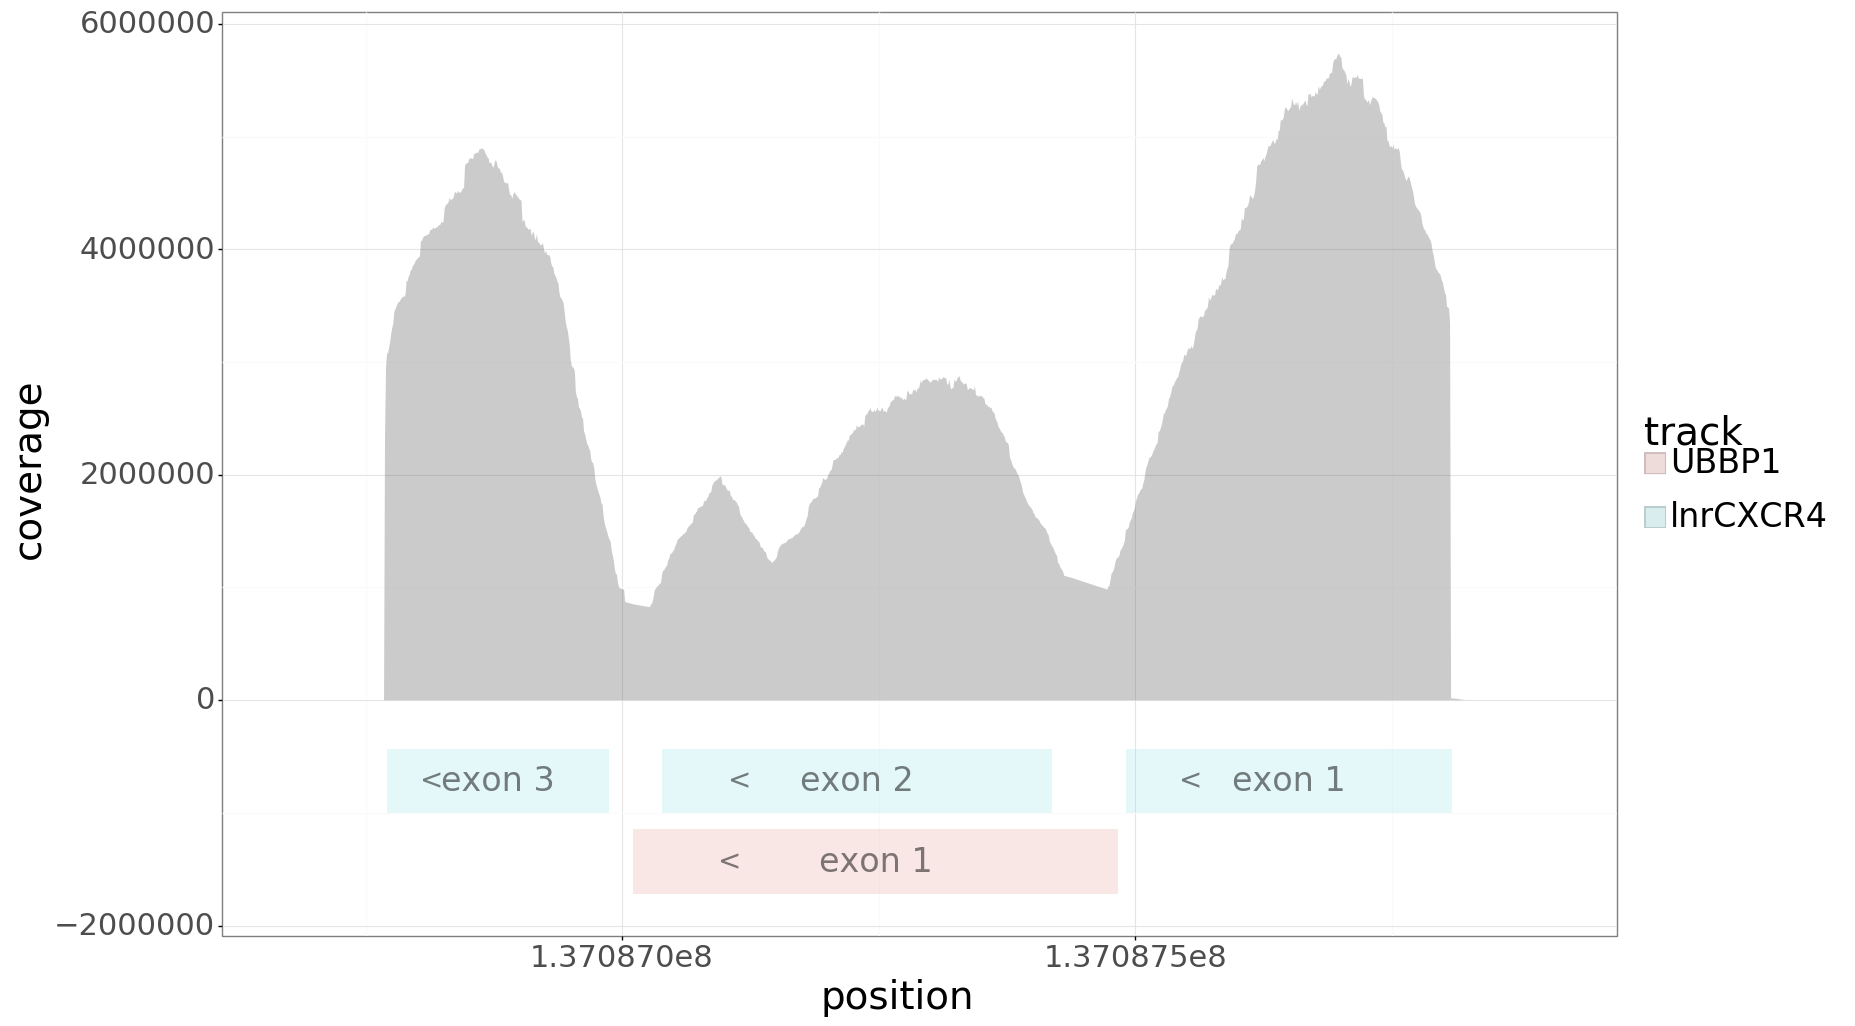

<ggplot: (-9223363259219335897)>

In [18]:
region_plot(None, 'yoon02', padding=100, strand=None,
            features=feature_df(gtf_, list(gtf_['exon'].values), feature_col='exon'))

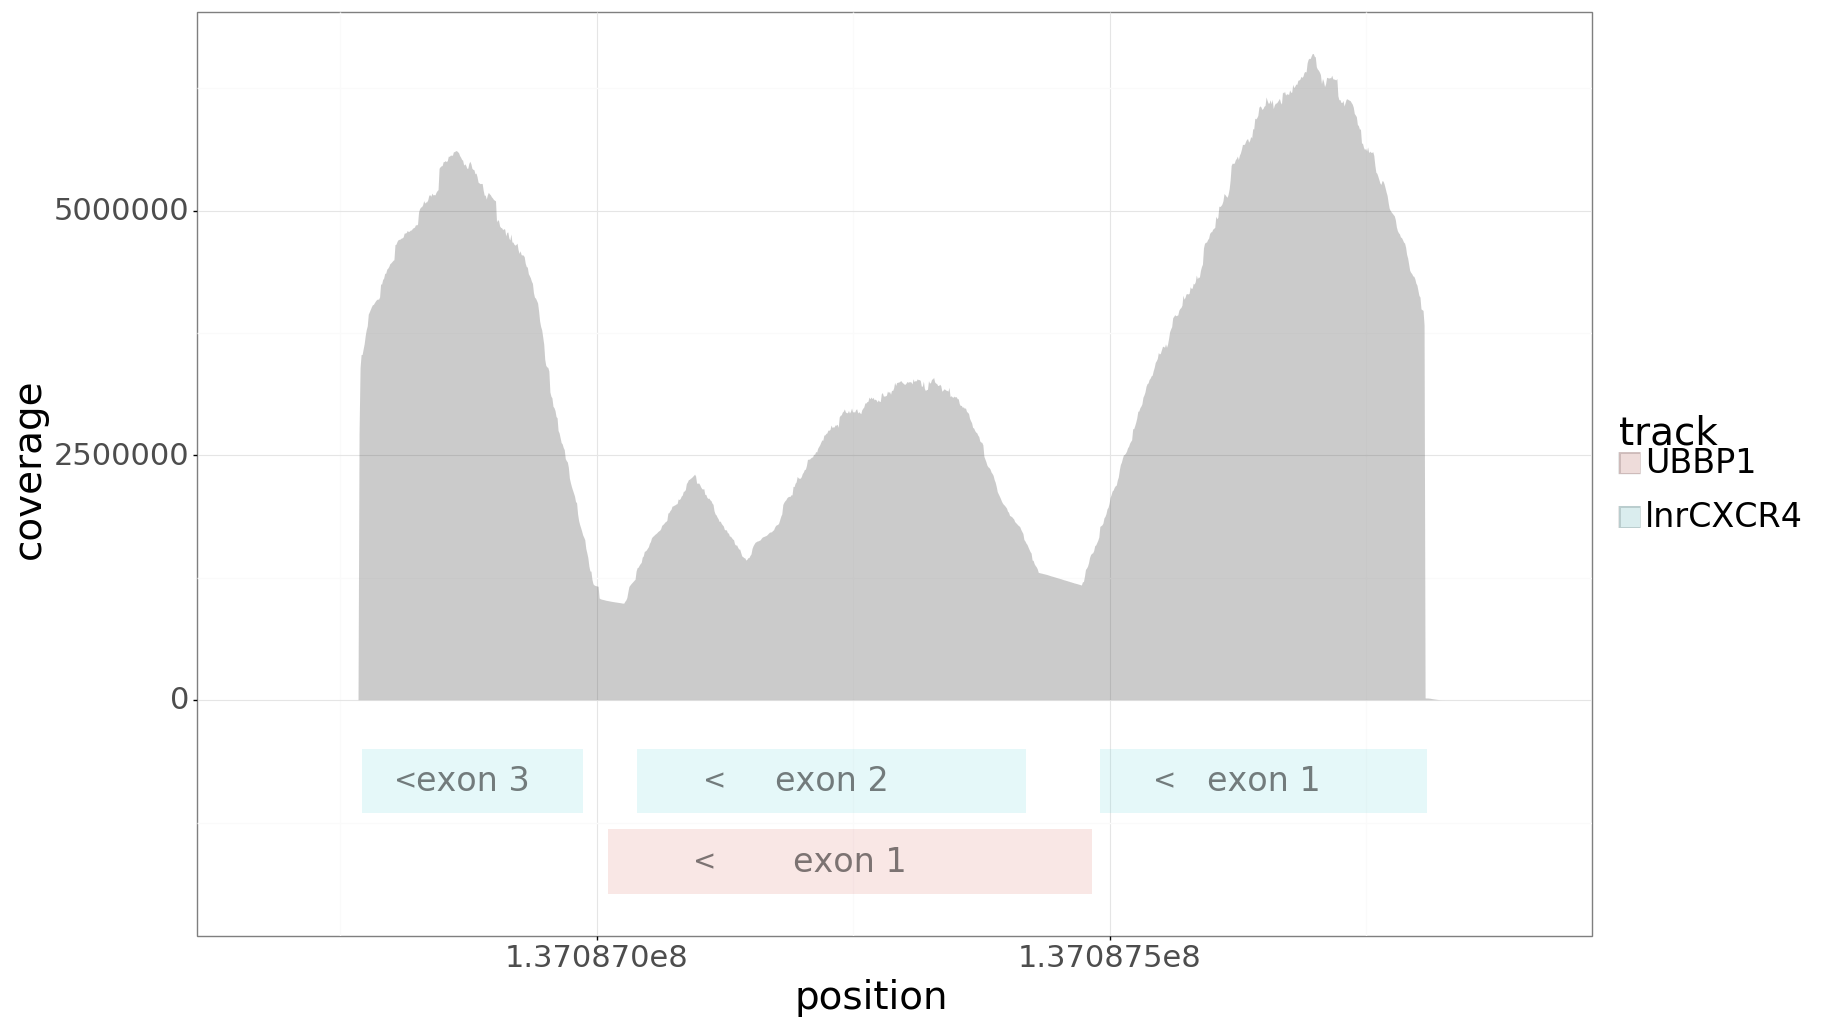

<ggplot: (8777635430948)>

In [19]:
region_plot(None, 'yoon03', padding=100, strand=None,
            features=feature_df(gtf_, list(gtf_['exon'].values), feature_col='exon'))